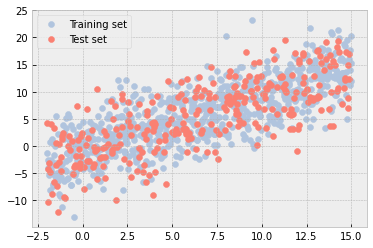

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import normal
plt.style.use('bmh')
%matplotlib inline

np.random.seed(3)

x = np.linspace(start = -2, stop=15, num=1000)
intercept, x_coef = -1, 1 
y = [x_coef*i + intercept for i in x]
y = [i+normal(0, 4) for i in y]

data = pd.DataFrame({'x': x, 'y': y})

# Split the data into training/testing sets
train, test = train_test_split(data, test_size=0.3)
X_train, X_test = train.x, test.x

# Split the targets into training/testing sets
y_train, y_test = train.y, test.y

plt.scatter(X_train, y_train, color='lightsteelblue', label = 'Training set')
plt.scatter(X_test, y_test, color='salmon', label = 'Test set')
plt.legend()

In [2]:
import mxnet as mx
from mxnet import nd, autograd, gluon


model_ctx=mx.gpu()
par={'weights':nd.random_normal(shape=1,ctx=model_ctx),'bias':nd.random_normal(shape=1,ctx=model_ctx)}
hyper={'alpha':nd.array(10.0, ctx=model_ctx)}

In [3]:
import sys
sys.path.append("../") 

# No Uncertainty

In [4]:
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.linear import linear

model=linear(hyper,ctx=model_ctx)
inference=sgd(model,par,step_size=0.05,ctx=model_ctx)

In [8]:
import numpy as np

X_train_tensor=X_train.values[:,np.newaxis]
y_train_tensor=y_train.values

In [6]:
par,loss=inference.fit(epochs=1000,batch_size=64,gamma=0.9,
                       X_train=X_train_tensor,y_train=y_train_tensor,verbose=False)

100%|██████████| 1000/1000 [00:43<00:00, 23.15it/s]


In [9]:
X_test_tensor=nd.array(X_test.values[:,np.newaxis],ctx=model_ctx)

In [8]:
y_pred=model.predict(par,X_test_tensor)

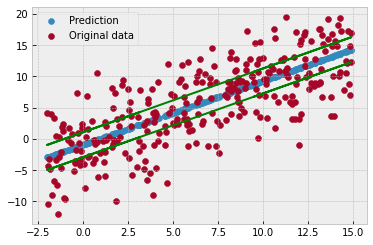

In [9]:
plt.scatter(X_test, y_pred.mean.asnumpy(), label = 'Prediction')
plt.plot(X_test,y_pred.mean.asnumpy()+2*y_pred.stddev,'g')
plt.plot(X_test,y_pred.mean.asnumpy()-2*y_pred.stddev,'g')
plt.scatter(X_test, y_test, label = 'Original data')
plt.legend()

# Aleatoric Uncertainty

In [14]:
par_aleatoric={'weights':nd.random_normal(shape=1,ctx=model_ctx),
     'bias':nd.random_normal(shape=1,ctx=model_ctx),
     'weights_scale':nd.random_normal(shape=1,ctx=model_ctx),
     'bias_scale':nd.random_normal(shape=1,ctx=model_ctx)}
hyper={'alpha':nd.array(10.0, ctx=model_ctx)}

In [15]:
from hamiltonian.models.linear import linear_aleatoric

model=linear_aleatoric(hyper,ctx=model_ctx)
inference=sgd(model,par_aleatoric,step_size=0.05,ctx=model_ctx)

In [16]:
par_aleatoric,loss=inference.fit(epochs=1000,batch_size=64,gamma=0.0,
                                 X_train=X_train_tensor,y_train=y_train_tensor,verbose=True)

  0%|          | 4/1000 [00:00<01:11, 13.93it/s]

loss: nan


 10%|█         | 104/1000 [00:06<00:51, 17.45it/s]

loss: nan


 20%|██        | 204/1000 [00:12<00:54, 14.60it/s]

loss: nan


 30%|███       | 304/1000 [00:19<00:45, 15.34it/s]

loss: nan


 40%|████      | 402/1000 [00:26<00:41, 14.50it/s]

loss: nan


 50%|█████     | 504/1000 [00:32<00:29, 16.85it/s]

loss: nan


 60%|██████    | 602/1000 [00:39<00:26, 15.16it/s]

loss: nan


 70%|███████   | 704/1000 [00:46<00:19, 15.25it/s]

loss: nan


 80%|████████  | 804/1000 [00:52<00:11, 16.48it/s]

loss: nan


 90%|█████████ | 904/1000 [00:59<00:06, 15.76it/s]

loss: nan


100%|██████████| 1000/1000 [01:05<00:00, 15.28it/s]


In [17]:
y_pred=model.predict(par_aleatoric,X_test_tensor)

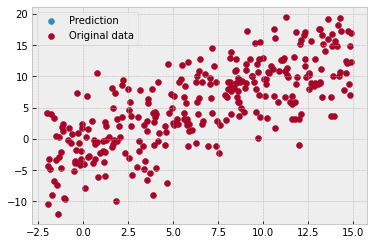

In [18]:
plt.scatter(X_test, y_pred.mean.asnumpy(), label = 'Prediction')
plt.plot(X_test,y_pred.mean.asnumpy()+2*y_pred.scale.asnumpy(),'g')
plt.plot(X_test,y_pred.mean.asnumpy()-2*y_pred.scale.asnumpy(),'g')
plt.scatter(X_test, y_test, label = 'Original data')
plt.legend()

In [19]:
y_pred.mean


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan n